Total frames: 322
Usable right heel frames: 322
Y-change threshold (filtering top 25%): 0.1022
Filtered - no preceding swing phase found: frame 4
Filtered - no preceding swing phase found: frame 39
Filtered - no preceding swing phase found: frame 46
Filtered - no preceding swing phase found: frame 80
Filtered - no preceding swing phase found: frame 122
Swing phase peak detected at frame 157: Y=0.753
Kept first minimum after swing at frame 186: Y=0.859
Filtered - already detected after this swing cycle: frame 200
Swing phase peak detected at frame 234: Y=0.769
Kept first minimum after swing at frame 275: Y=0.870
Swing phase peak detected at frame 307: Y=0.774

Found 2 Local Minima:
Minimum 1: Frame 186, Time 6.200s, Y = 0.85903
Minimum 2: Frame 275, Time 9.167s, Y = 0.87040

Ground truth right foot steps: 4
GT: Frame 22, Time 0.733s, Y = 0.83893
GT: Frame 100, Time 3.333s, Y = 0.84336
GT: Frame 178, Time 5.933s, Y = 0.86123
GT: Frame 255, Time 8.500s, Y = 0.88737

Detected step interval

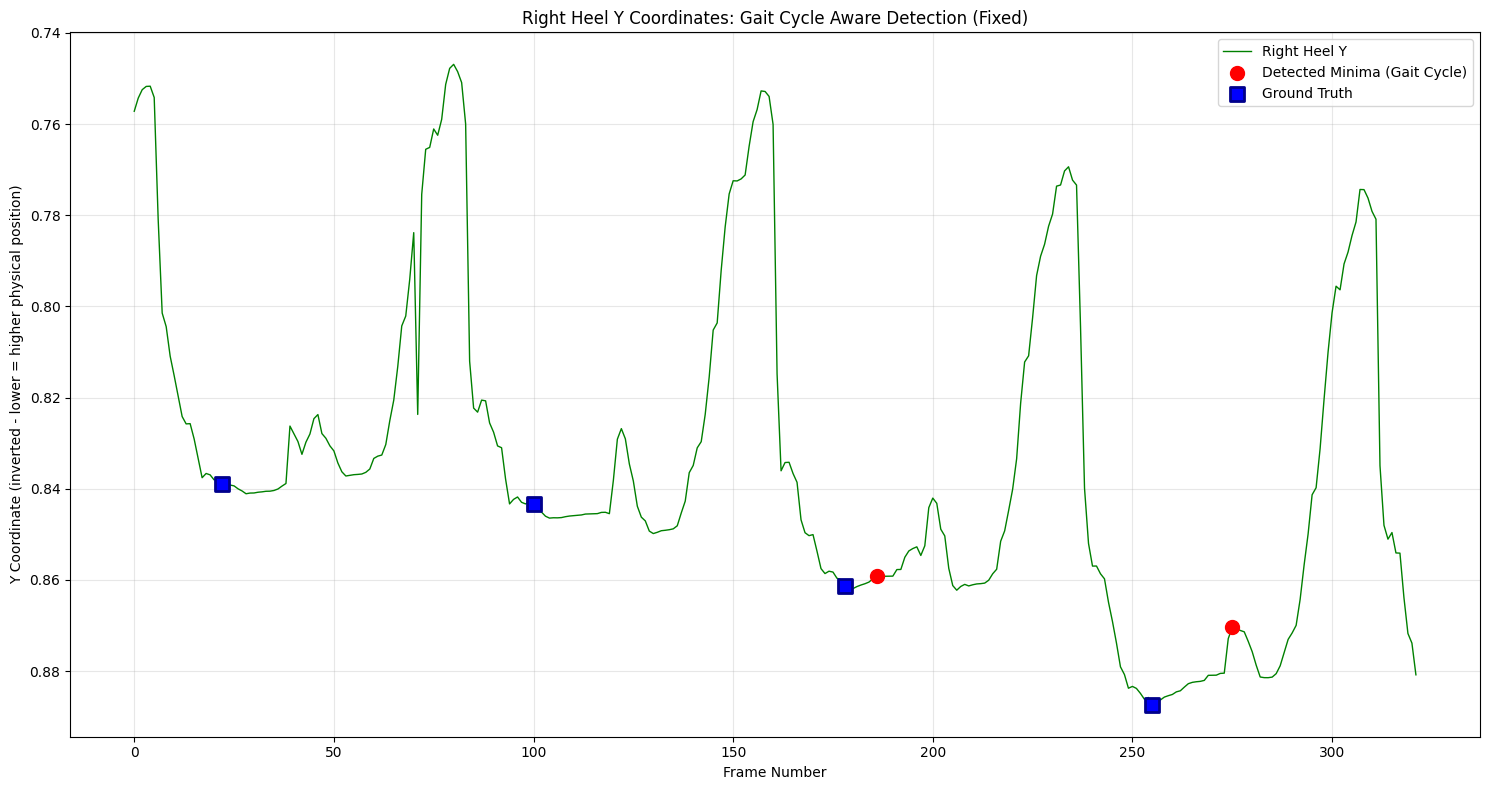


COMPARISON:
Ground truth right steps: 4
Detected minima: 2
Detection ratio: 0.50


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load the CSV from your heel detector
df = pd.read_csv('/Users/yejinbang/Documents/GitHub/sfx-project/data/walk4_frame_data_v1.csv')

# Load ground truth data
with open('/Users/yejinbang/Documents/GitHub/sfx-project/data/test_videos/walk4_ground_truth.json', 'r') as f:
    gt_data = json.load(f)

# Filter out frames where right heel is not usable (low confidence)
df_filtered = df[df['right_heel_usable'] == True].copy()

print(f"Total frames: {len(df)}")
print(f"Usable right heel frames: {len(df_filtered)}")

def find_local_minima_with_gait_cycle(df_data, window_size=3, min_distance=10, jump_threshold_percentile=75):
    """
    Find local minima with gait cycle awareness - only detect first minimum after swing phase
    (Adopted from successful left foot logic)
    """
    minima = []
    y_values = df_data['right_heel_y'].values
    frames = df_data['frame_number'].values
    timestamps = df_data['timestamp'].values
    
    n = len(y_values)
    
    # First pass: find all potential minima and their Y-change magnitudes
    potential_minima = []
    
    for i in range(window_size, n - window_size):
        current_val = y_values[i]
        
        # Check if it's a local minimum
        is_minimum = True
        for j in range(i - window_size, i + window_size + 1):
            if j != i and y_values[j] <= current_val:
                is_minimum = False
                break
        
        if is_minimum:
            # Calculate the Y-change magnitude around this minimum
            look_back = min(15, i)
            look_forward = min(15, n - i - 1)
            
            if look_back > 0 and look_forward > 0:
                before_y = np.mean(y_values[i-look_back:i])
                after_y = np.mean(y_values[i+1:i+look_forward+1])
                
                drop_magnitude = abs(before_y - current_val)
                rise_magnitude = abs(after_y - current_val)
                total_change = drop_magnitude + rise_magnitude
                
                potential_minima.append({
                    'index': i,
                    'frame_number': frames[i],
                    'timestamp': timestamps[i],
                    'y_value': current_val,
                    'y_change_magnitude': total_change
                })
    
    if not potential_minima:
        return []
    
    # Calculate threshold for Y-change magnitude
    y_changes = [m['y_change_magnitude'] for m in potential_minima]
    change_threshold = np.percentile(y_changes, jump_threshold_percentile)
    
    print(f"Y-change threshold (filtering top {100-jump_threshold_percentile}%): {change_threshold:.4f}")
    
    # Second pass: apply gait cycle logic
    last_swing_peak_frame = -1
    
    for minimum in potential_minima:
        if minimum['y_change_magnitude'] <= change_threshold:
            current_y = minimum['y_value']
            current_frame = minimum['frame_number']
            
            # Detect if we're transitioning from swing to stance
            swing_peaks_nearby = [m for m in potential_minima 
                                if m['y_change_magnitude'] > change_threshold 
                                and m['frame_number'] < current_frame 
                                and current_frame - m['frame_number'] < 60  # Within last 60 frames
                                and m['y_value'] < current_y - 0.05]  # Significantly lower Y
            
            if swing_peaks_nearby:
                # We found a swing peak before this minimum
                latest_swing = max(swing_peaks_nearby, key=lambda x: x['frame_number'])
                
                # Only detect if this is the first minimum after a swing peak
                if latest_swing['frame_number'] > last_swing_peak_frame:
                    # This is the first detection after a new swing phase
                    if not minima or (minimum['index'] - minima[-1]['index']) >= min_distance:
                        minima.append({
                            'index': minimum['index'],
                            'frame_number': minimum['frame_number'],
                            'timestamp': minimum['timestamp'],
                            'y_value': minimum['y_value']
                        })
                        last_swing_peak_frame = latest_swing['frame_number']
                        print(f"Kept first minimum after swing at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}")
                    else:
                        print(f"Filtered by distance: frame {minimum['frame_number']}")
                else:
                    print(f"Filtered - already detected after this swing cycle: frame {minimum['frame_number']}")
            else:
                print(f"Filtered - no preceding swing phase found: frame {minimum['frame_number']}")
        else:
            print(f"Swing phase peak detected at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}")
    
    return minima

# Find local minima using gait cycle approach
minima = find_local_minima_with_gait_cycle(df_filtered, window_size=3, min_distance=10, jump_threshold_percentile=75)

print(f"\nFound {len(minima)} Local Minima:")
for i, minimum in enumerate(minima):
    print(f"Minimum {i+1}: Frame {minimum['frame_number']}, "
          f"Time {minimum['timestamp']:.3f}s, Y = {minimum['y_value']:.5f}")

# Extract ground truth RIGHT foot steps  
gt_right_steps = [step for step in gt_data['annotations'] if step['foot'] == 'right']
print(f"\nGround truth right foot steps: {len(gt_right_steps)}")

# Get Y coordinates for ground truth frames
gt_frames = []
gt_y_values = []
for gt_step in gt_right_steps:
    frame_num = gt_step['frame']
    matching_row = df_filtered[df_filtered['frame_number'] == frame_num]
    if not matching_row.empty:
        gt_frames.append(frame_num)
        gt_y_values.append(matching_row['right_heel_y'].iloc[0])
        print(f"GT: Frame {frame_num}, Time {gt_step['timestamp']:.3f}s, Y = {matching_row['right_heel_y'].iloc[0]:.5f}")

# Calculate intervals between steps
if len(minima) > 1:
    intervals = []
    for i in range(1, len(minima)):
        interval = minima[i]['timestamp'] - minima[i-1]['timestamp']
        intervals.append(interval)
    
    print(f"\nDetected step intervals:")
    for i, interval in enumerate(intervals):
        print(f"  Interval {i+1}: {interval:.3f}s")
    
    print(f"\nTiming statistics:")
    print(f"  Average interval: {np.mean(intervals):.3f}s")
    print(f"  Std deviation: {np.std(intervals):.3f}s")

# Visualize results
plt.figure(figsize=(15, 8))
plt.plot(df_filtered['frame_number'], df_filtered['right_heel_y'], 'g-', linewidth=1, label='Right Heel Y')

# Mark detected minima (RED dots)
if minima:
    min_frames = [m['frame_number'] for m in minima]
    min_y_vals = [m['y_value'] for m in minima]
    plt.scatter(min_frames, min_y_vals, color='red', s=100, zorder=5, label='Detected Minima (Gait Cycle)')

# Mark ground truth (BLUE squares)
if gt_frames:
    plt.scatter(gt_frames, gt_y_values, color='blue', s=100, marker='s', zorder=6, 
               label='Ground Truth', edgecolors='darkblue', linewidth=2)

plt.xlabel('Frame Number')
plt.ylabel('Y Coordinate (inverted - lower = higher physical position)')
plt.title('Right Heel Y Coordinates: Gait Cycle Aware Detection (Fixed)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Compare detection accuracy
print(f"\n{'='*50}")
print("COMPARISON:")
print(f"Ground truth right steps: {len(gt_right_steps)}")
print(f"Detected minima: {len(minima)}")
print(f"Detection ratio: {len(minima)/len(gt_right_steps):.2f}" if gt_right_steps else "N/A")

